In [14]:
#https://habr.com/ru/articles/505616/
!pip install gdown
!pip install -U scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [31]:
#load dataset

import os
import gdown
import zipfile
import matplotlib.image as mpimg
import skimage as ski
import random
import numpy as np
from sklearn.model_selection import train_test_split

def shift_rotate(source):
  transform = ski.transform.AffineTransform(translation=(random.randint(-3, 3), random.randint(-3, 3)))
  result = ski.transform.warp(image, transform, mode="wrap")
  return ski.transform.rotate(result, random.randint(-11, 11), cval=255, preserve_range=True)

name_url = "https://drive.google.com/file/d/1AxqIfZbfqXFdL4vwvXqSmDrQdRqHuU4y/view?usp=drivesdk"
name_archive = "latin.zip"
name_ds = "Latin"

if not os.path.exists(name_archive):
  print("downloading from google disk...")
  gdown.download(name_url, name_archive, quiet=False,fuzzy=True)

if not os.path.exists('Latin'):
  print("unzip archive...")
  with zipfile.ZipFile(name_archive, 'r') as zip_ref:
    zip_ref.extractall()

plt.figure(figsize=(20, 4))

max_letters_count = 6000
letters_count = 0
train = []
test = []
print("load dataset...")
for letter in os.listdir(name_ds):
  letters_count += 1
  count = 0
  path = name_ds + '/' + letter
  print("{0}...".format(path))
  sources = []
  inserts = []
  for file in os.listdir(name_ds + '/' + letter):
    count += 1
    filepath = name_ds + '/' + letter + '/' + file
    source = mpimg.imread(filepath)
    sources.append(source)
    image = ski.transform.resize(source, (28, 28))
    image = ski.color.rgb2gray(ski.color.rgba2rgb(image))
    inserts.append(image)
    if count >= max_letters_count: break
  sources_letters_size = len(sources)
  index = 0
  while count < max_letters_count:
    count = count + 1
    image = shift_rotate(sources[index])
    image = ski.transform.resize(source, (28, 28))
    image = ski.color.rgb2gray(ski.color.rgba2rgb(image))
    inserts.append(image)
    index = (index + 1) % sources_letters_size

  _train, _test, _, _  = train_test_split(inserts, [0]*max_letters_count, random_state=42, train_size = 0.80)
  train.extend(_train)
  test.extend(_test)

train = np.array(train)
train = train.reshape(train.shape[0], -1)
test = np.array(test)
test = test.reshape(test.shape[0], -1)
print('letters count {0}'.format(letters_count))
print('train size {0}'.format(train.shape))
print('test size {0}'.format(test.shape))


load dataset...
Latin/L...
Latin/A...
Latin/H...
Latin/V...
Latin/D...
Latin/Y...
Latin/B...
Latin/W...
Latin/K...
Latin/S...
Latin/E...
Latin/P...
Latin/X...
Latin/C...
Latin/N...
Latin/M...
Latin/R...
Latin/F...
Latin/O...
Latin/J...
Latin/Z...
Latin/G...
Latin/U...
Latin/I...
Latin/Q...
Latin/T...
letters count 26
train size (124800, 784)
test size (31200, 784)


<Figure size 2000x400 with 0 Axes>

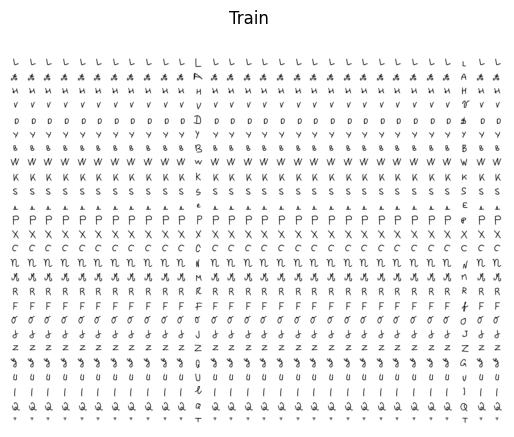

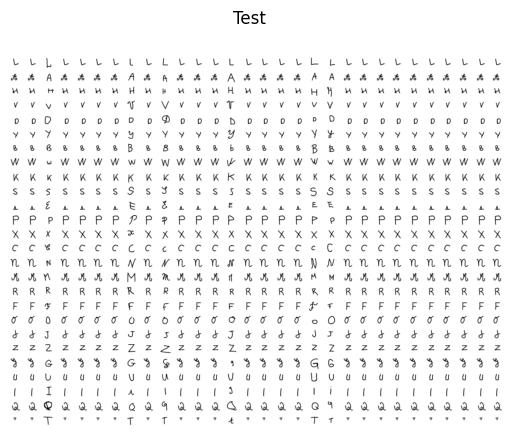

In [32]:
#show datatets
import matplotlib.pyplot as plt

columns = 30

fig, axs = plt.subplots(nrows=letters_count, ncols=columns)
for i in range(letters_count):
  for j in range(columns):
    axs[i, j].imshow(train[(i * int(train.shape[0] / letters_count)) + j].reshape(28, 28), cmap='gray')
    axs[i, j].axis('off')
fig.suptitle('Train')
fig.show()

fig, axs = plt.subplots(nrows=letters_count, ncols=columns)
for i in range(letters_count):
  for j in range(columns):
    axs[i, j].imshow(test[(i * int(test.shape[0] / letters_count)) + j].reshape(28, 28), cmap='gray')
    axs[i, j].axis('off')
fig.suptitle('Test')
fig.show()


In [100]:
#training
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

# Параметры сети и обучения
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = 64
latent_dim = 2
batch_size = 128
epochs = 50

# Функция перепараметризации
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.8 * z_log_var) * epsilon

# Энкодер
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Декодер
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE модель
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# Функция потерь
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Обучение VAE
vae.fit(train, epochs=epochs, batch_size=batch_size, validation_data=(test, None))
vae.summary()

# Визуализация результатов
encoder.summary()
decoder.summary()


Epoch 1/50
975/975 [==============================] - 5s 5ms/step - loss: 156.5430 - val_loss: 132.2657
Epoch 2/50
975/975 [==============================] - 5s 5ms/step - loss: 123.5380 - val_loss: 117.3716
Epoch 3/50
975/975 [==============================] - 4s 4ms/step - loss: 110.0150 - val_loss: 106.4061
Epoch 4/50
975/975 [==============================] - 4s 4ms/step - loss: 101.0592 - val_loss: 99.4608
Epoch 5/50
975/975 [==============================] - 5s 5ms/step - loss: 94.9725 - val_loss: 95.9887
Epoch 6/50
975/975 [==============================] - 4s 4ms/step - loss: 90.8620 - val_loss: 91.1670
Epoch 7/50
975/975 [==============================] - 5s 5ms/step - loss: 88.0375 - val_loss: 89.0026
Epoch 8/50
975/975 [==============================] - 4s 4ms/step - loss: 85.8278 - val_loss: 87.2179
Epoch 9/50
975/975 [==============================] - 4s 4ms/step - loss: 84.1409 - val_loss: 85.5350
Epoch 10/50
975/975 [==============================] - 5s 5ms/step - loss: 

1/1 [==============================] - 0s 15ms/step


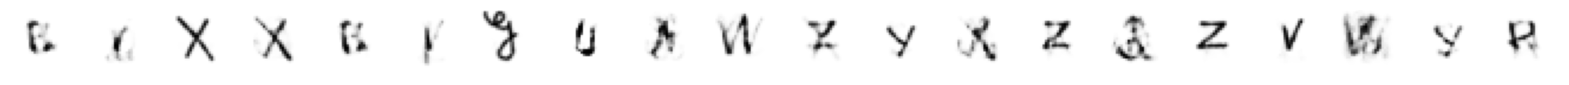

In [103]:
#show result
n = 20
z_sample = np.random.normal(size=(n, latent_dim))
x_decoded = decoder.predict(z_sample)

# Визуализация сгенерированных изображений
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_decoded[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()